# File Autoencoder

### Feature Preprocessing

In [ ]:
from sklearn.model_selection import train_test_split
from ml_utils import feature_from_dir, translate_bytes
import time

test_set_dir = '/Users/ryan/Documents/CS/CDAC/official_xtract/sampler_dataset/pub8'

raw_features = feature_from_dir(test_set_dir, byte_num=512)
untranslated_features = translate_bytes(raw_features)

x = untranslated_features / 255
x_train, x_test, _, _ = train_test_split(x, x)


### Model

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import EarlyStopping

input_size = len(x_train[0])

input_layer = Input((input_size,))
encoded = Dense(256, activation='relu')(input_layer)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(decoded) 
decoded = Dense(input_size, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
autoencoder.summary()

history = autoencoder.fit(x_train, x_train,
                          epochs=100,
                          batch_size = 256,
                          shuffle=True,
                          callbacks=[EarlyStopping()],
                          validation_data=(x_test, x_test))

encoder = Model(input_layer, encoded)


### Results visualization

In [ ]:
%%capture --no-display 
import matplotlib.pyplot as plt

# set up figure
f = plt.figure(figsize=(12,5))
f.add_subplot(1,2, 1)

# plot accuracy as a function of epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')

# plot loss as a function of epoch
f.add_subplot(1,2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show(block=True)

# File Classifier

### Loading Autoencoder Model

In [ ]:
from keras.models import load_model

encoder = load_model("encoder_model.h5")

### Feature and Label Grabbing

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from ml_utils import grab_labels, feature_from_file, translate_bytes
import csv

le = LabelEncoder()
naivetruth_path = "/Users/ryan/Documents/CS/CDAC/xtract_autoencoder/automated_training_results/cdiac_subset.csv"

labels, file_paths = grab_labels(naivetruth_path)
labels.pop(0) #Gets rid of headers
file_paths.pop(0)

x = []

for file_path in file_paths:
    x.append(feature_from_file(file_path))

#x = encoder.predict(translate_bytes(x))
x = translate_bytes(x)
y = to_categorical(le.fit_transform(labels), 6)

x_train, x_test, y_train, y_test = train_test_split(x, y)

print(y_train)

[[0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


In [6]:
print(set(labels))
for unique in set(labels):
    print("{} is {} and there are {} files".format(unique, ((labels.count(unique) / len(labels)) * 100), labels.count(unique)))

{'netcdf', 'tabular', 'image', 'unknown', 'json/xml', 'freetext'}
netcdf is 1.7376330619912335 and there are 111 files
tabular is 41.96931747025673 and there are 2681 files
image is 6.058234189104571 and there are 387 files
unknown is 5.009392611145898 and there are 320 files
json/xml is 7.654978083907327 and there are 489 files
freetext is 37.57044458359424 and there are 2400 files


## Deep Classifier Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

classifier_dim = len(x[0])
output_dim = len(y[0])

classifier_model = Sequential()
classifier_model.add(Dense(32, activation='relu', input_shape=(classifier_dim,)))
classifier_model.add(Dense(28, activation='relu'))
classifier_model.add(Dense(24, activation='relu'))
classifier_model.add(Dense(16, activation='relu'))
classifier_model.add(Dense(8, activation='relu'))
classifier_model.add(Dense(output_dim, activation='softmax'))

classifier_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
classifier_model.summary()

history = classifier_model.fit(x_train, y_train,
                               epochs=15,
                               batch_size = 16,
                               shuffle=True,
                               validation_data=(x_test, y_test)) 

In [ ]:
%%capture --no-display 

import matplotlib.pyplot as plt

# set up figure
f = plt.figure(figsize=(12,5))
f.add_subplot(1,2, 1)

# plot accuracy as a function of epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')

# plot loss as a function of epoch
f.add_subplot(1,2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show(block=True)

### Validation Results (Binary Classifier):
 - Trained on cdiac_subset:
     - cdiac_naivetruth: 0.87
     - nist_subset: 0.77
     - cdiac_subset: 0.91
 - Trained on cdiac_naivetruth:
     - cdiac_naivetruth: 0.92
     - nist_subset: 0.82
     - cdiac_subset: 0.94
 - Trained on nist_subset:
     - cdiac_naivetruth: 0.65
     - nist_subset: 0.96
     - cdiac_subset: 0.65 

### Validation Results (Categorical Classifier) (32,28,24,16,8,6 inputs):
 - Trained on cdiac_subset:
     - cdiac_naivetruth: 0.80
     - nist_subset: 0.50
     - cdiac_subset: 0.89
 - Trained on cdiac_naivetruth (adam optimizer):
     - cdiac_naivetruth: 0.91
     - nist_subset: 0.50
     - cdiac_subset: 0.87
 - Trained on nist_subset:
     - cdiac_naivetruth: 0.40
     - nist_subset: 0.93
     - cdiac_subset: 0.43

## Convolutional Model

In [2]:
from keras.models import Sequential
from keras.layers import Conv1D, Dense, MaxPooling1D, GlobalMaxPooling1D, Reshape, GlobalAveragePooling1D, Flatten


classifier_model = Sequential()
classifier_model.add(Reshape((len(x[0]), 1), input_shape=(len(x[0]),)))
classifier_model.add(Conv1D(50, 127, activation='relu'))
classifier_model.add(MaxPooling1D(pool_size=2))
classifier_model.add(Conv1D(50, 127, activation='relu'))
classifier_model.add(GlobalMaxPooling1D(pool_size=2))
classifier_model.add(Flatten())
classifier_model.add(Dense(32, activation='relu'))
classifier_model.add(Dense(28, activation='relu'))
classifier_model.add(Dense(24, activation='relu'))
classifier_model.add(Dense(16, activation='relu'))
classifier_model.add(Dense(8, activation='relu'))
classifier_model.add(Dense(6, activation='softmax'))

classifier_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
classifier_model.summary()

history = classifier_model.fit(x_train, y_train,
                               epochs=20,
                               batch_size = 16,
                               shuffle=True,
                               validation_data=(x_test, y_test)) 

W1106 14:15:39.861039 4565276096 deprecation_wrapper.py:119] From /Users/ryan/anaconda3/envs/xtract/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1106 14:15:39.872485 4565276096 deprecation_wrapper.py:119] From /Users/ryan/anaconda3/envs/xtract/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1106 14:15:39.878981 4565276096 deprecation_wrapper.py:119] From /Users/ryan/anaconda3/envs/xtract/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1106 14:15:39.892719 4565276096 deprecation_wrapper.py:119] From /Users/ryan/anaconda3/envs/xtract/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 512, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 386, 50)           6400      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 193, 50)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 67, 50)            317550    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 33, 50)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1650)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                52832     
__________

W1106 14:15:40.109236 4565276096 deprecation_wrapper.py:119] From /Users/ryan/anaconda3/envs/xtract/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 10757 samples, validate on 3586 samples
Epoch 1/20
10757/10757 [==============================] - 18s 2ms/step - loss: 1.1236 - acc: 0.5371 - val_loss: 0.7338 - val_acc: 0.7549
Epoch 2/20
10757/10757 [==============================] - 18s 2ms/step - loss: 0.6732 - acc: 0.7612 - val_loss: 0.5676 - val_acc: 0.7869
Epoch 3/20
10757/10757 [==============================] - 18s 2ms/step - loss: 0.5058 - acc: 0.8212 - val_loss: 0.5170 - val_acc: 0.8093
Epoch 4/20
10757/10757 [==============================] - 18s 2ms/step - loss: 0.4674 - acc: 0.8333 - val_loss: 0.5019 - val_acc: 0.8076
Epoch 5/20
10757/10757 [==============================] - 19s 2ms/step - loss: 0.4085 - acc: 0.8557 - val_loss: 0.4184 - val_acc: 0.8600
Epoch 6/20
10757/10757 [==============================] - 19s 2ms/step - loss: 0.3782 - acc: 0.8773 - val_loss: 0.3981 - val_acc: 0.8606
Epoch 7/20
10757/10757 [==============================] - 19s 2ms/step - loss: 0.3546 - acc: 0.8827 - val_loss: 0.3893 - val_acc:

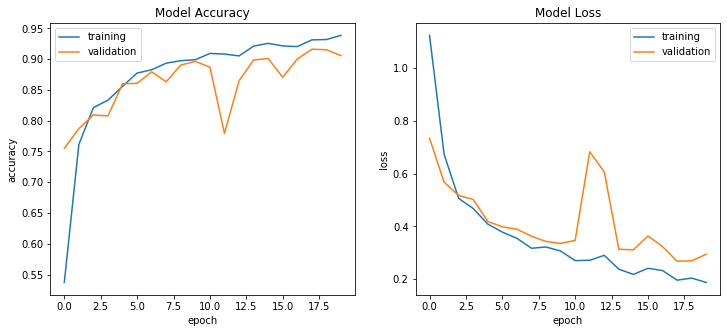

In [3]:
%%capture --no-display 

import matplotlib.pyplot as plt

# set up figure
f = plt.figure(figsize=(12,5))
f.add_subplot(1,2, 1)

# plot accuracy as a function of epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')

# plot loss as a function of epoch
f.add_subplot(1,2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show(block=True)

## Validation

In [4]:
import csv
from ml_utils import grab_labels, feature_from_file, translate_bytes, features_from_list

validation_set = "/Users/ryan/Documents/CS/CDAC/xtract_autoencoder/automated_training_results/nist_subset.csv"

validation_labels, validation_paths = grab_labels(validation_set)
validation_labels.pop(0) #Gets rid of headers
validation_paths.pop(0)

# for idx, label in enumerate(validation_labels):
#     if not(label == "tabular"):
#         validation_labels[idx] = "blah"

validation_features = features_from_list(validation_paths)

#validation_encoded = encoder.predict(translate_bytes(validation_features))
validation_encoded = translate_bytes(validation_features)
validation_labels = to_categorical(le.fit_transform(validation_labels), 6)
validation_predictions = classifier_model.predict(validation_encoded, verbose=True)

26988/26988 [==============================] - 5s 169us/step


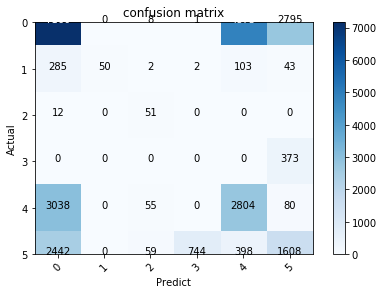

In [5]:
from ml_utils import convert_to_index, plot_confusion_matrix
from pycm import ConfusionMatrix
import numpy as np

# apply conversion function to data
y_test_ind = convert_to_index(validation_labels)
y_pred_test_ind = convert_to_index(validation_predictions)

# compute confusion matrix
cm_test = ConfusionMatrix(y_test_ind, y_pred_test_ind)
np.set_printoptions(precision=2)

# plot confusion matrix result
plt.figure()
plot_confusion_matrix(cm_test,title='confusion matrix')

In [6]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

validation_accuracy = accuracy_score(y_test_ind, y_pred_test_ind)
validation_recall = recall_score(y_test_ind, y_pred_test_ind, average='micro')

print(validation_accuracy)
print(validation_recall)

0.4325255669186305
0.4325255669186305
